# Clustering

The goal of this notebook is to give an answer to the following questions:
1. Does the distribution contain different sub-populations? How many?
2. What's the threshold between the classes?

In [1]:
import numpy as np

In [103]:
import sys
sys.path.append(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ML\GammaRayBursts\Utilities')
import utils
import plot_settings

In [104]:
url = 'https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt'
raw, names = utils.read_data(url)

C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ML\GammaRayBursts\Utilities\utils.py:22: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [105]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [106]:
ra = np.array(raw[3]).astype(float)
de = np.array(raw[4]).astype(float)

In [107]:
T90, T90_err, fluence, fluence_err, RS = zip(*[(float(a), float(b), float(c), float(d), float(h)) for a, b, c, d, h in zip(raw[6], raw[7], raw[9], raw[10], raw[11]) 
                                           if a != '-999' and b != '-999' and float(b)!=0 
                                           and c != '-999' and float(c) != 0
                                           and d != '-999' and float(d) != 0
                                           and h != '-999' and float(h) != 0])

In [108]:
T90         = np.array(T90)
T90_err     = np.array(T90_err)
fluence     = np.array(fluence)
fluence_err = np.array(fluence_err)
RS          = np.array(RS)


In [109]:
import matplotlib.pyplot as plt

## Clustering GMM (No errors)

### Let's cluster on T90 and fluence

In [110]:
T90, T90_err, fluence, fluence_err = zip(*[(float(a), float(b), float(c), float(d)) for a, b, c, d in zip(raw[6], raw[7], raw[9], raw[10]) 
                                           if a != '-999' and b != '-999' and float(b)!=0 
                                           and c != '-999' and float(c) != 0
                                           and d != '-999' and float(d) != 0
                                           ])

In [111]:
DD = np.vstack([np.log10(T90), np.log10(fluence)]).T

In [112]:
from sklearn import preprocessing

In [113]:
scaler = preprocessing.StandardScaler()

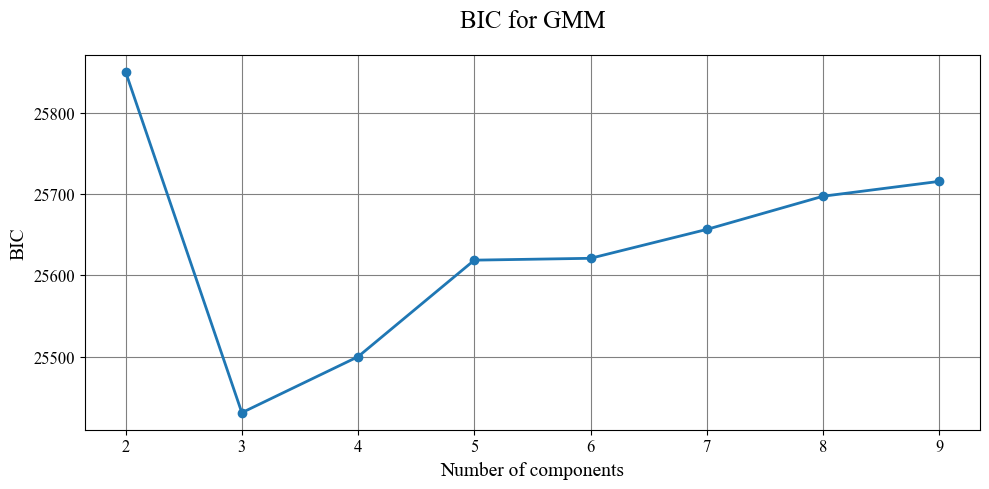

In [114]:
n_clusters, score = utils.Gauss_peaks(DD, 2, 10, True)

In [115]:
labels, model = utils.GM_fit(DD, n_clusters, False)

In [116]:
centroids = model.means_
weights = model.weights_
ll = model.score_samples(DD)

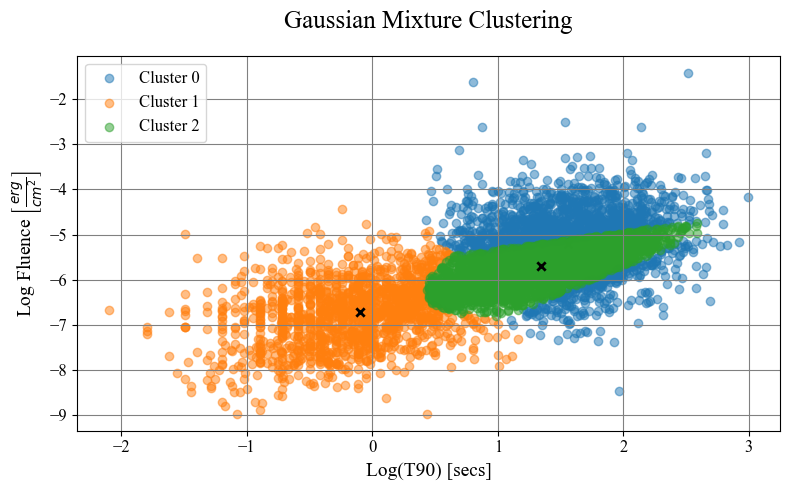

In [117]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()

#ax.scatter(np.log10(T90), np.log10(fluence), marker='o', color='gray', label='Raw Data', alpha=0.5)

for i,c in enumerate(centroids):
    ax.scatter(DD.T[0][labels==i],DD.T[1][labels==i], marker='o', alpha=0.5, label=f'Cluster {i}')
    ax.scatter(c[0], c[1], marker='x', color='black')
    

ax.set_title('Gaussian Mixture Clustering')
ax.set_xlabel('Log(T90) [secs]')
ax.set_ylabel(r'Log Fluence $\left[\frac{erg}{cm^2}\right]$')
ax.legend()

Let's try clustering on Redshift and fluence

In [118]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [119]:
fluence, RS = zip(*[(float(a), float(b)) for a, b, in zip(raw[9], raw[11]) 
                                           if a != '-999' and b != '-999' 
                                           and float(b)!=0 and float(a)!=0
                                           ])

In [120]:
R = np.vstack([np.log10(fluence), RS]).T

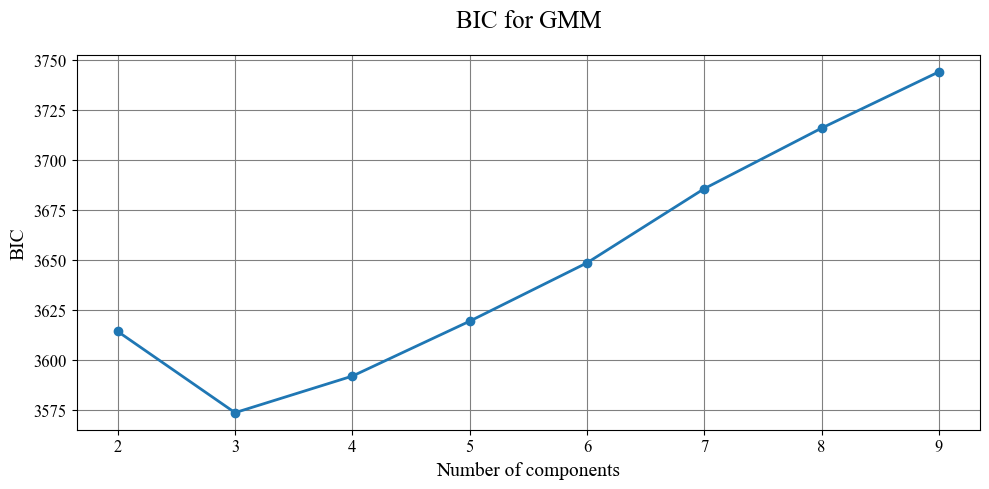

In [121]:
n_clusters, score = utils.Gauss_peaks(R, 2, 10, True)

In [122]:
labels, model = utils.GM_fit(R, n_clusters, False)

In [123]:
centroids = model.means_
weights = model.weights_
ll = model.score_samples(R)

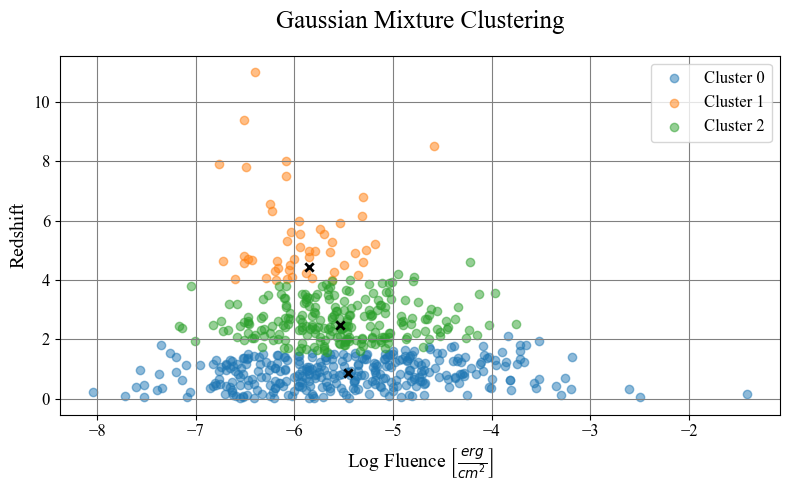

In [124]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()

#ax.scatter(np.log10(T90), np.log10(fluence), marker='o', color='gray', label='Raw Data', alpha=0.5)

for i,c in enumerate(centroids):
    ax.scatter(R.T[0][labels==i],R.T[1][labels==i], marker='o', alpha=0.5, label=f'Cluster {i}')
    ax.scatter(c[0], c[1], marker='x', color='black')
    

ax.set_title('Gaussian Mixture Clustering')
ax.set_xlabel(r'Log Fluence $\left[\frac{erg}{cm^2}\right]$')
ax.set_ylabel('Redshift')
ax.legend()

 ## Cluster KMeans (No errors)

In [125]:
from sklearn.cluster import KMeans

In [126]:
KM = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(scaler.fit_transform(DD))

In [127]:
print('Score' , KM.score(DD))

Score -182000.643814356


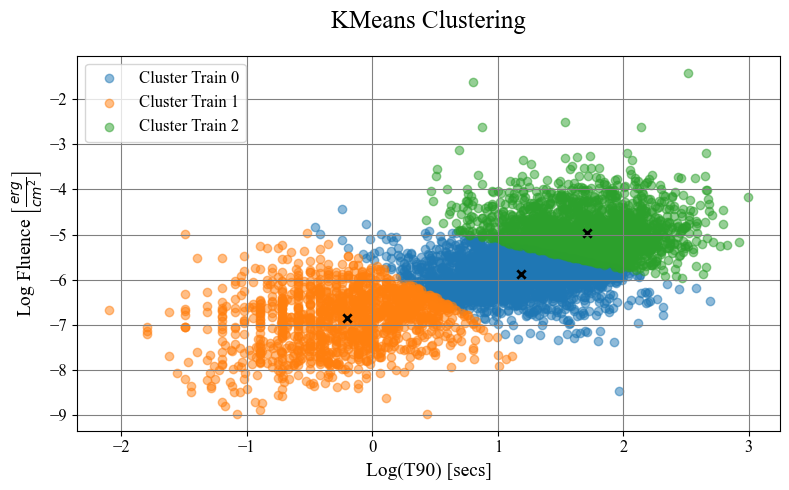

In [128]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()

#ax.scatter(np.log10(T90), np.log10(fluence), marker='o', color='gray', label='Raw Data', alpha=0.5)

for i,c in enumerate(scaler.inverse_transform(KM.cluster_centers_)):
    ax.scatter(DD.T[0][KM.labels_==i],DD.T[1][KM.labels_==i], marker='o', alpha=0.5, label=f'Cluster Train {i}')
    ax.scatter(c[0], c[1], marker='x', color='black')

ax.set_title('KMeans Clustering')
ax.set_xlabel('Log(T90) [secs]')
ax.set_ylabel(r'Log Fluence $\left[\frac{erg}{cm^2}\right]$')
ax.legend()

## Mean Shift (No Errors)

In [132]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [133]:
bw = estimate_bandwidth(DD, quantile=0.2)

In [134]:
MS = MeanShift(bandwidth=bw)

In [136]:
MS.fit(DD)

MeanShift(bandwidth=np.float64(0.7317306376971056))

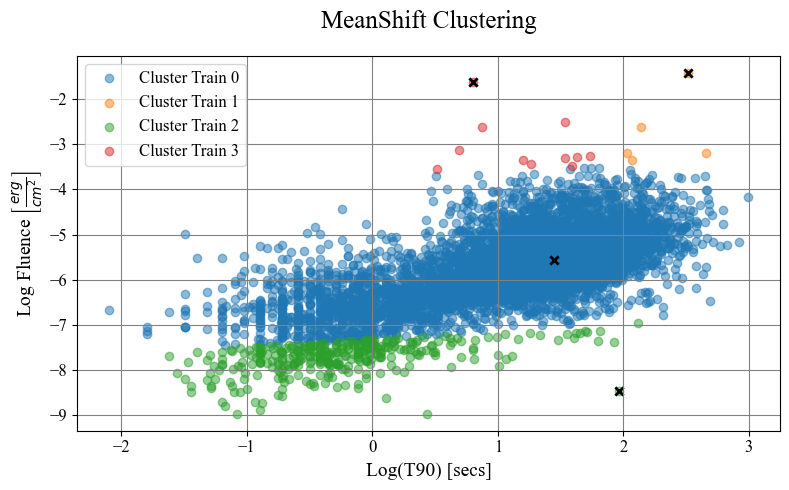

In [142]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()

for i,c in enumerate(MS.cluster_centers_):
    ax.scatter(DD.T[0][MS.labels_==i],DD.T[1][MS.labels_==i], marker='o', alpha=0.5, label=f'Cluster Train {i}')
    ax.scatter(c[0], c[1], marker='x', color='black')

ax.set_title('MeanShift Clustering')
ax.set_xlabel('Log(T90) [secs]')
ax.set_ylabel(r'Log Fluence $\left[\frac{erg}{cm^2}\right]$')
ax.legend()

## DBScan (No Errors)

In [143]:
from sklearn.cluster import DBSCAN

In [144]:
DB = DBSCAN()

In [145]:
DB.fit(DD)

DBSCAN()

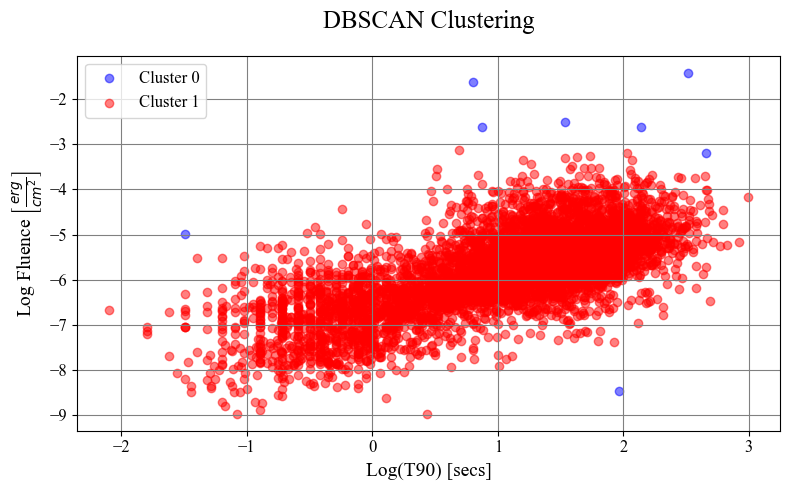

In [146]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()


#for i in range(MS.cluster_centers_.shape[0]):
ax.scatter(DD.T[0][DB.labels_==-1],DD.T[1][DB.labels_==-1], marker='o', alpha=0.5, color='blue', label=f'Cluster {0}')
ax.scatter(DD.T[0][DB.labels_==0],DD.T[1][DB.labels_==0], marker='o', alpha=0.5, color='red',  label=f'Cluster {1}')
ax.set_title('DBSCAN Clustering')
ax.set_xlabel('Log(T90) [secs]')
ax.set_ylabel(r'Log Fluence $\left[\frac{erg}{cm^2}\right]$')
ax.legend()